# Imports

In [327]:
# import
import torch
import logging
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from utils.arg_extract import get_args
from utils.experiment_evaluator import evaluate_experiment
from utils.experiment import Experiment
from argparse import Namespace
from utils.experiment_evaluator import image_prepro, create_evaluation_dataloader, get_test_predictions_pairs, save_sequence_plots
import os
from utils.io import save
plt.ioff()
from utils.io import load
batch_images_all = load('batches.pickle')
import scipy as scp

import configparser
config = configparser.ConfigParser()
config.read('../config.ini')
# config['paths']['exp_folder']
        
data_directory = config['paths']['data_base']
experiments = [dI for dI in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, dI))]

# Model

In [8]:
exp = 'convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c'

belated = False
dd = {'experiment_name': exp,
        'num_epochs': 1,
        'num_workers': 1,
        'test_starting_point': 15,
        'num_total_output_frames':80,
        'debug': False}

args_new = Namespace(**dd)
experiment = Experiment(args_new)
experiment.device='cpu'
experiment.load_from_disk(test=True)

# Viz latent space of ConvLSTM

In [350]:
import scipy.ndimage
model = experiment.model.cpu()
params = model.cpu().state_dict()

def show_kernels(param, lines, rows, interp='nearest', feature_map=0, deconv=False):
    p0 = params[param+'.weight']
    print(p0.size())
    fig, axarr = plt.subplots(lines, rows, figsize=(rows, lines))

    for i in range(lines):
        for k in range(rows):
            kk = i * rows + k
            if kk < p0.size(0 if deconv else 1):
                img = p0[kk, feature_map, :] if deconv else p0[feature_map, kk, :] 
                img = scp.ndimage.zoom(img, zoom=3)
                axarr[i, k].imshow(img, cmap='gray', interpolation=interp, vmin=p0.min(), vmax=p0.max())
            axarr[i, k].set_yticks([])
            axarr[i, k].set_xticks([])
    plt.show()

In [351]:
def mean_activation_histogram(param, deconv=False):
    p0 = params[param+'.weight']
    p0b = params[param+'.bias']
    dim = (0,2,3) if deconv else (1,2,3)
    pp = p0.mean(dim) + p0b
    plt.hist(pp)
    plt.show()

## First layer kernels

torch.Size([8, 1, 3, 3])


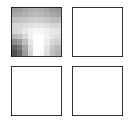

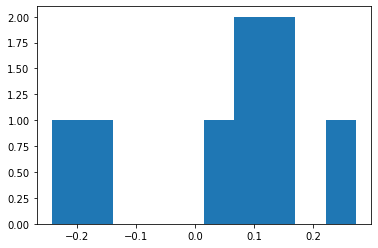

In [344]:
# Conv Layer 1
lines = 2
rows = 2
feature_map = 0

param = 'encoder.stage1.conv1_leaky_1'
show_kernels(param, lines, rows, interp='none', feature_map=feature_map)
mean_activation_histogram(param)

In [515]:
model

EncoderForecaster(
  (encoder): Encoder(
    (stage1): Sequential(
      (conv1_leaky_1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (leaky_conv1_leaky_1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (rnn1): ConvLSTMCell(
      (_conv): Conv2d(72, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (stage2): Sequential(
      (conv2_leaky_1): Conv2d(64, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (leaky_conv2_leaky_1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (rnn2): ConvLSTMCell(
      (_conv): Conv2d(384, 768, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (stage3): Sequential(
      (conv3_leaky_1): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (leaky_conv3_leaky_1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (rnn3): ConvLSTMCell(
      (_conv): Conv2d(384, 768, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (forecaster): Forecaster(


torch.Size([256, 72, 3, 3])


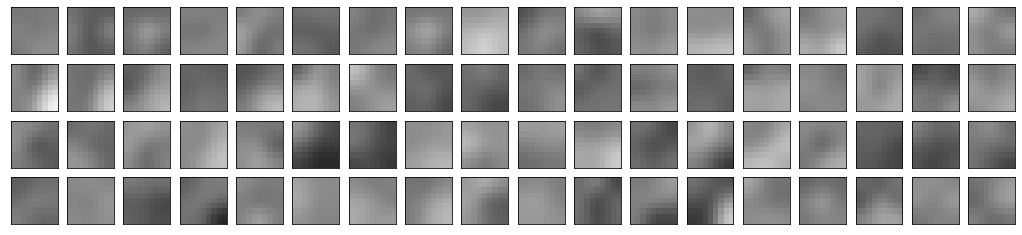

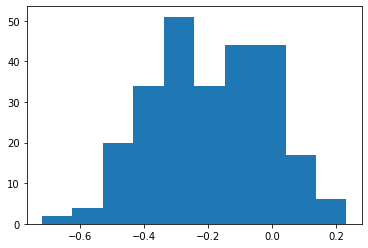

In [349]:
# RNN1 
lines = 4
rows = 18
feature_map = 1

param = 'encoder.rnn1._conv'
show_kernels(param, lines, rows, interp='none', feature_map=feature_map)
mean_activation_histogram(param)

torch.Size([192, 64, 3, 3])


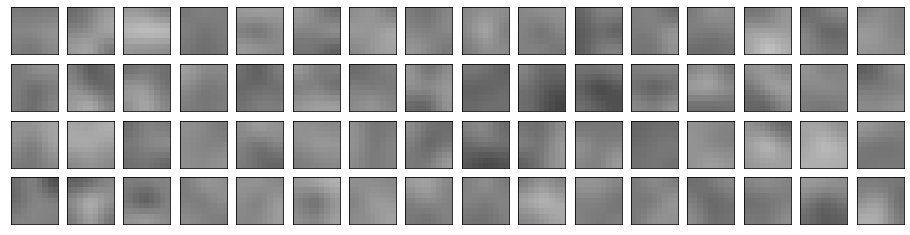

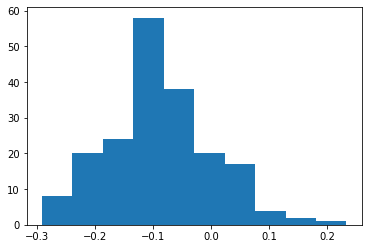

In [346]:
# Layer 2
lines = 4
rows = 16
feature_map = 0

param = 'encoder.stage2.conv2_leaky_1'
show_kernels(param, lines, rows, interp='none', feature_map=feature_map)
mean_activation_histogram(param)

torch.Size([768, 384, 3, 3])


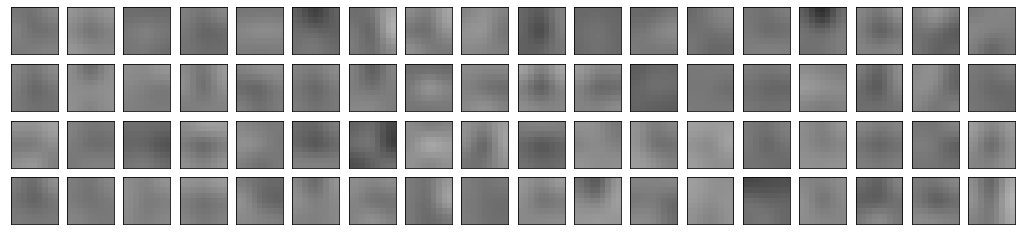

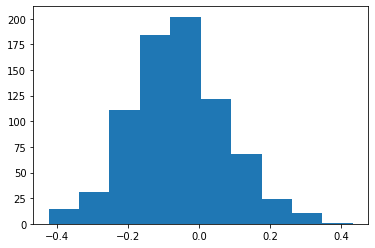

In [352]:
# RNN2
lines = 4
rows = 18
feature_map = 1

param = 'encoder.rnn2._conv'
show_kernels(param, lines, rows, interp='none', feature_map=feature_map)
mean_activation_histogram(param)

torch.Size([192, 192, 3, 3])


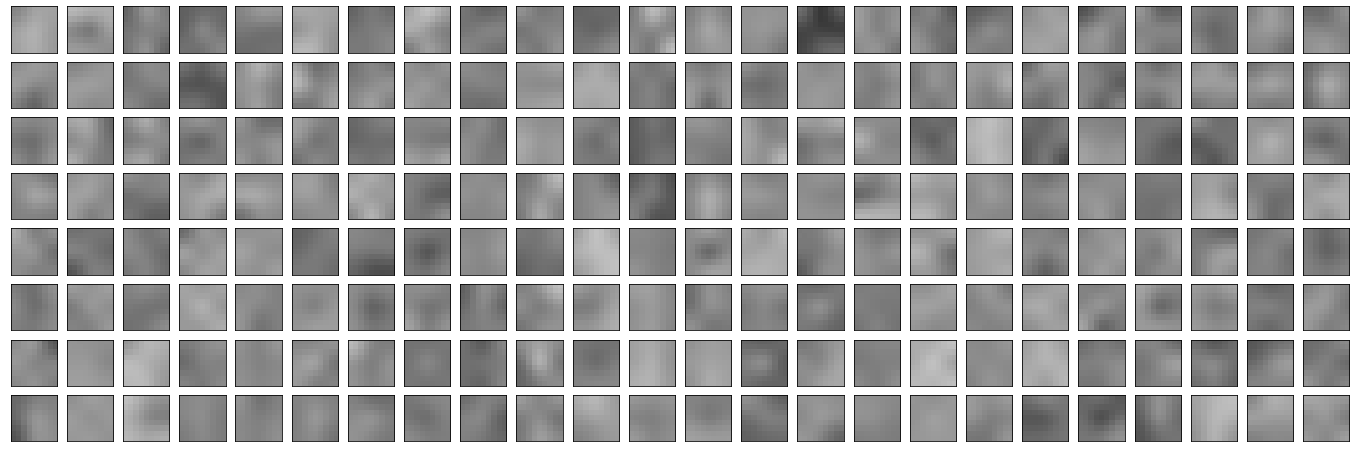

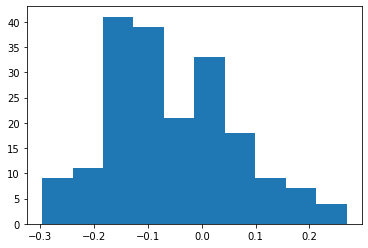

In [353]:
lines = 8
rows = 24
feature_map = 0

param = 'encoder.stage3.conv3_leaky_1'
show_kernels(param, lines, rows, interp='none', feature_map=feature_map)
mean_activation_histogram(param)

torch.Size([768, 384, 3, 3])


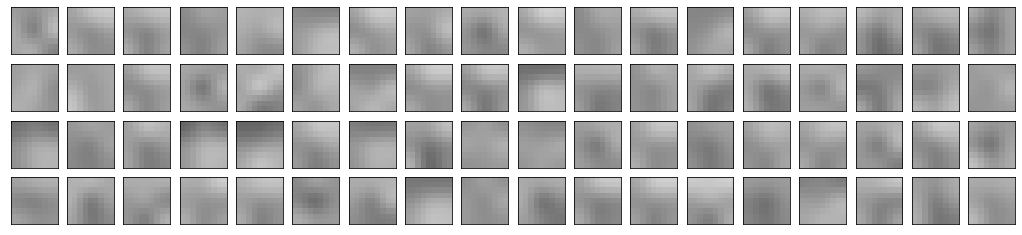

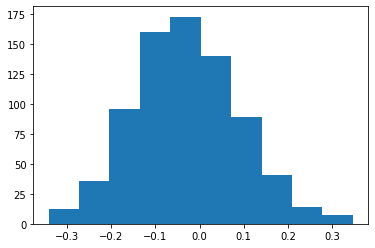

In [354]:
# RNN3
lines = 4
rows = 18
feature_map = 0

param = 'encoder.rnn3._conv'
show_kernels(param, lines, rows, interp='none', feature_map=feature_map)
mean_activation_histogram(param)

## Deconv kernels

torch.Size([768, 384, 3, 3])


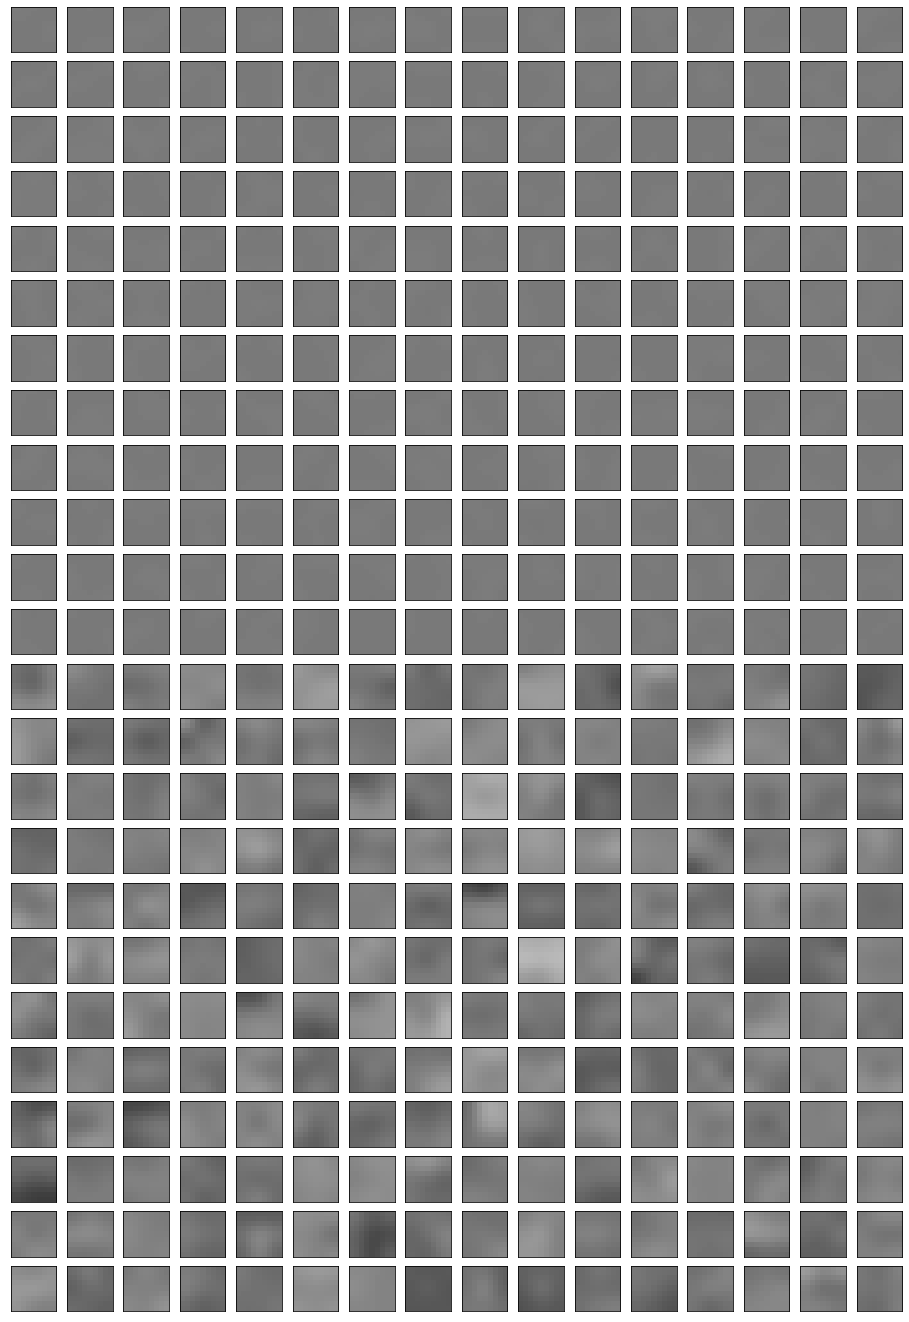

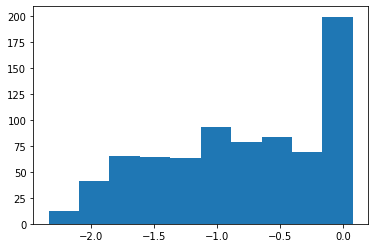

In [516]:
# Decoder RNN3 
lines = 24
rows = 16
feature_map = 0

param = 'forecaster.rnn3._conv'
show_kernels(param, lines, rows, interp='none', feature_map=feature_map, deconv=False)
mean_activation_histogram(param)

torch.Size([192, 192, 4, 4])


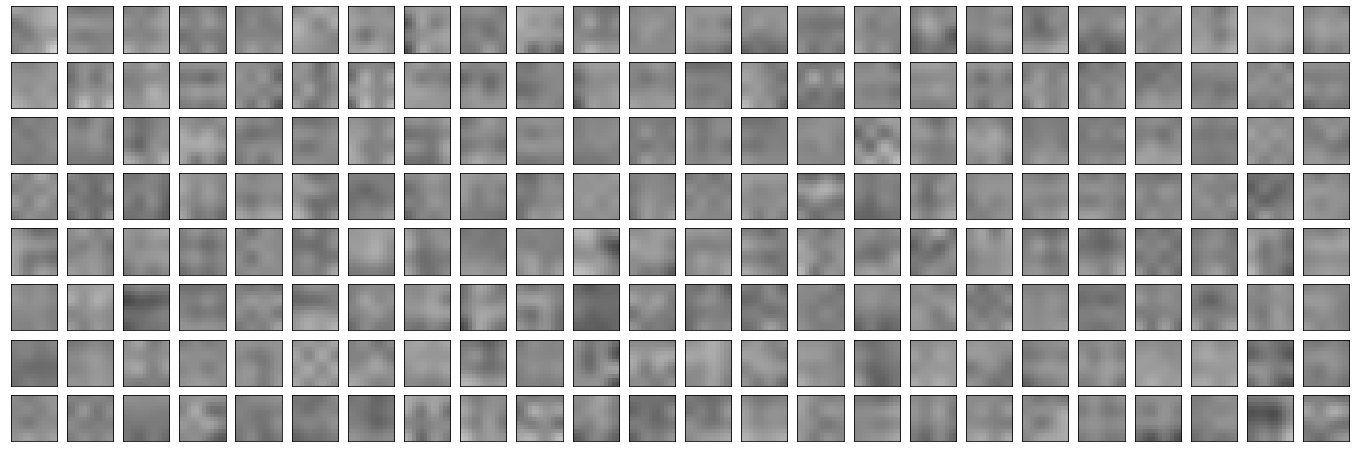

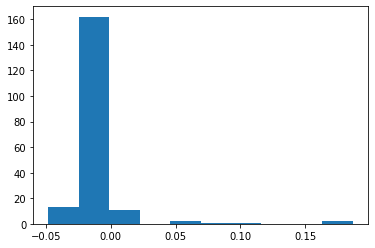

In [364]:
# STAGE 3 DECONV 1
lines = 8
rows = 24
feature_map = 1

param = 'forecaster.stage3.deconv1_leaky_1'
show_kernels(param, lines, rows, interp='none', feature_map=feature_map, deconv=True)
mean_activation_histogram(param, deconv=True)

torch.Size([768, 384, 3, 3])


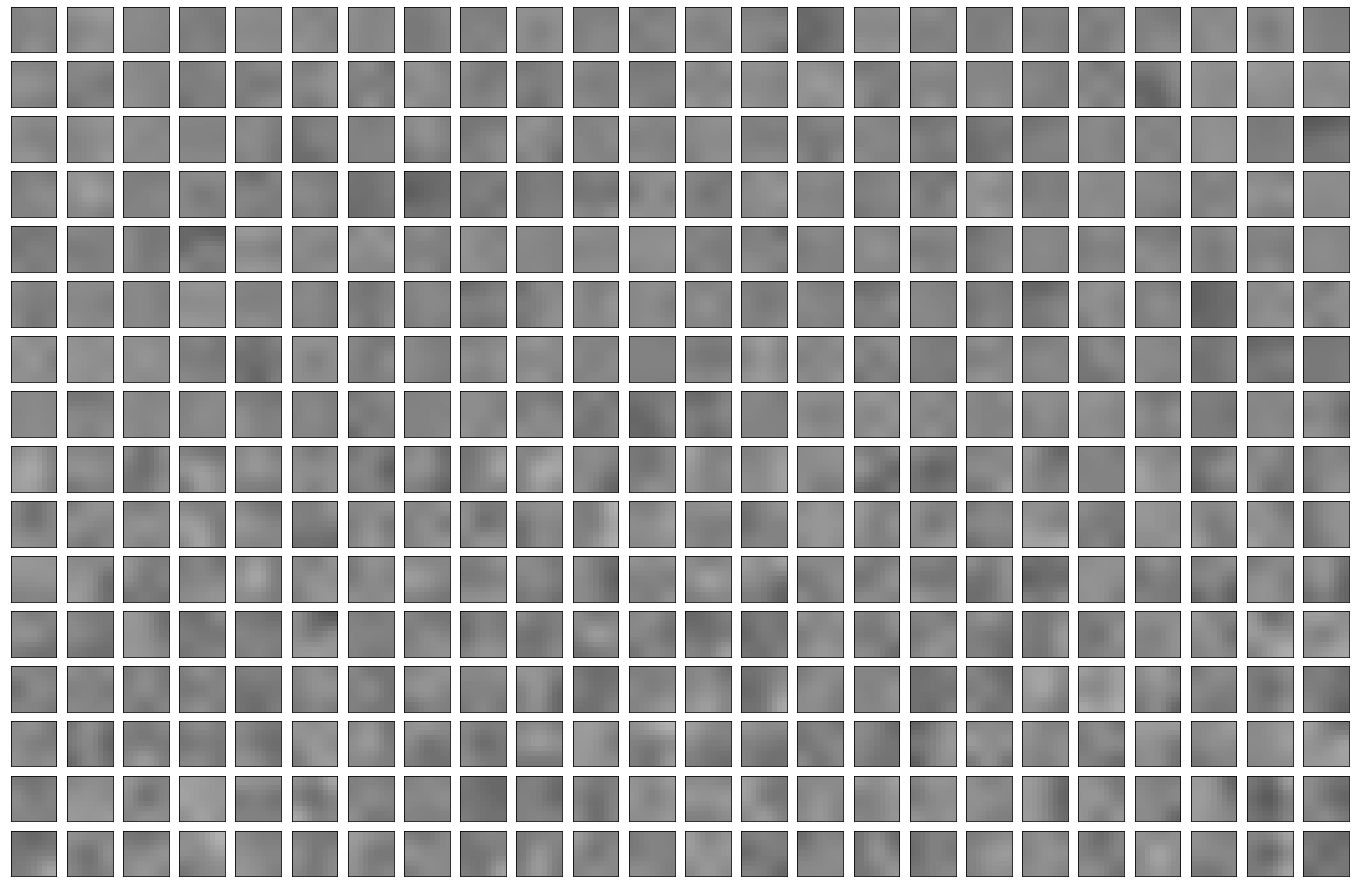

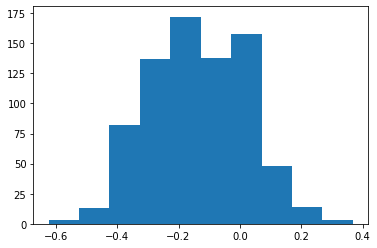

In [357]:
# RNN2 
lines = 16
rows = 24
feature_map = 0

param = 'forecaster.rnn2._conv'
show_kernels(param, lines, rows, interp='none', feature_map=feature_map)
mean_activation_histogram(param)

torch.Size([192, 64, 4, 4])


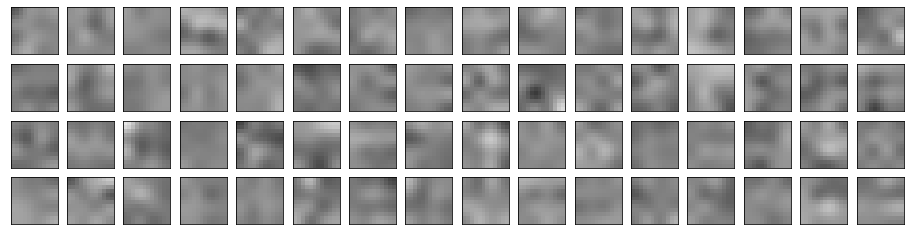

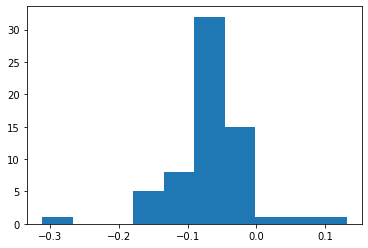

In [358]:
# STAGE 2 DECONV 2
lines = 4
rows = 16
feature_map = 1

param = 'forecaster.stage2.deconv2_leaky_1'
show_kernels(param, lines, rows, interp='none', feature_map=feature_map, deconv=True)
mean_activation_histogram(param, deconv=True)

torch.Size([256, 128, 3, 3])


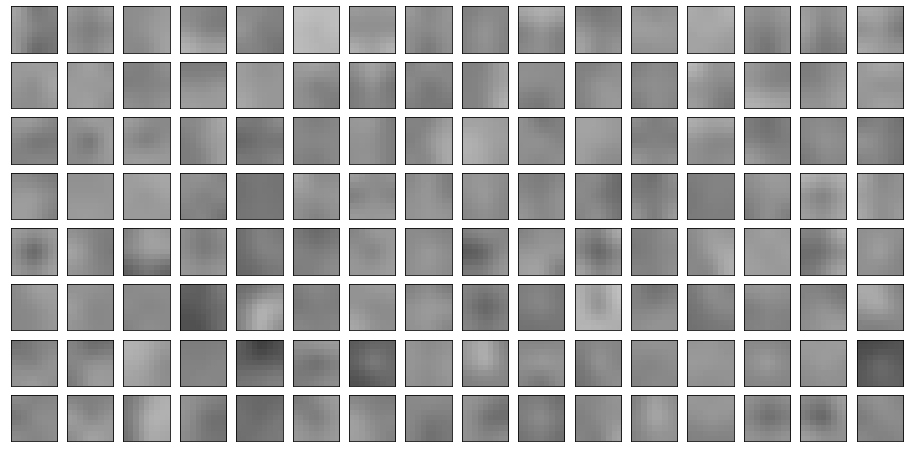

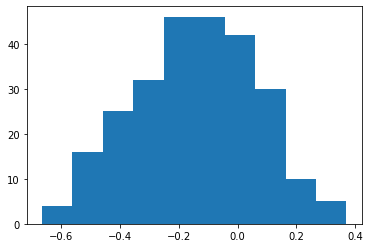

In [359]:
# RNN1
lines = 8
rows = 16
feature_map = 0

param = 'forecaster.rnn1._conv'
show_kernels(param, lines, rows, interp='none', feature_map=feature_map, deconv=False)
mean_activation_histogram(param)

torch.Size([64, 8, 4, 4])


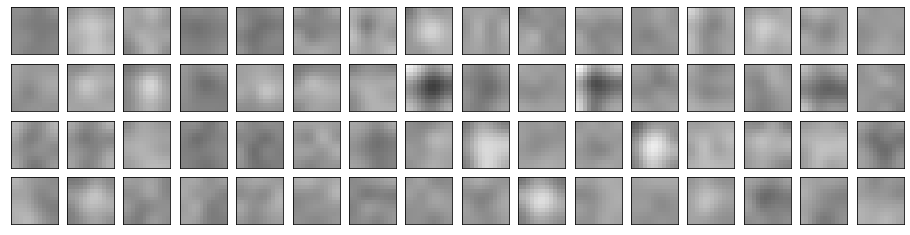

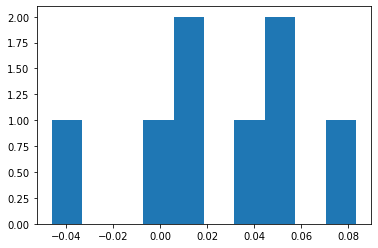

In [369]:
# STAGE 1 DECONV 3
lines = 4
rows = 16
feature_map = 2

param = 'forecaster.stage1.deconv3_leaky_1'
show_kernels(param, lines, rows, interp='none', feature_map=feature_map, deconv=True)
mean_activation_histogram(param, deconv=True)

torch.Size([8, 8, 3, 3])


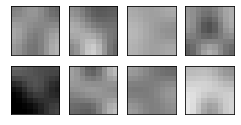

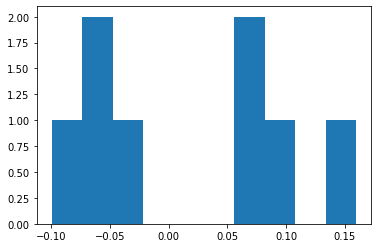

In [370]:
# STAGE 1 CONV 3
lines = 2
rows = 4
feature_map = 1

param = 'forecaster.stage1.conv3_leaky_2'
show_kernels(param, lines, rows, interp='none', feature_map=feature_map, deconv=True)
mean_activation_histogram(param, deconv=True)

torch.Size([1, 8, 1, 1])


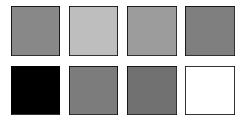

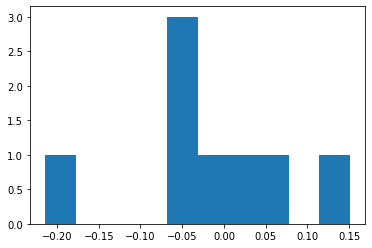

In [514]:
# STAGE 1 CONV 3 3
lines = 2
rows = 4
feature_map = 0

param = 'forecaster.stage1.conv3_3'
show_kernels(param, lines, rows, interp='none', feature_map=feature_map, deconv=False)
mean_activation_histogram(param, deconv=True)

# Visualize feature maps

In [371]:
# Visualize feature maps
activation = {}
hooks = {}

In [372]:
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output #.detach()
#         print(name)
    return hook

In [373]:
for n,h in hooks.items():
    h.remove()

for name, module in model.named_modules():
    hooks[name] = module.register_forward_hook(get_activation(name))

In [537]:
# 'Test_1', 'Test_2', 'Test_3', 
# 'Lines_1', 'Lines_2', 'Lines_3',
# 'Double_Drop_1', 'Double_Drop_2', 'Double_Drop_3', 
# 'Illumination_135_1', 'Illumination_135_2', 'Illumination_135_3', 
# 'Illumination_Random_1', 'Illumination_Random_2', 'Illumination_Random_3', 
# 'Shallow_Depth_1', 'Shallow_Depth_2', 'Shallow_Depth_3', 
# 'Smaller_Tub_1', 'Smaller_Tub_2', 'Smaller_Tub_3', 
# 'Bigger_Tub_1', 'Bigger_Tub_2', 'Bigger_Tub_3', 
# 'Fixed_Tub_1', 'Fixed_Tub_2', 'Fixed_Tub_3'

test_set = 'Smaller_Tub_1'
batch_images = batch_images_all[test_set]

starting_point = 10
num_total_output_frames = 80
batch_index=0
model.eval()
num_input_frames = model.get_num_input_frames()
with torch.no_grad():
    input_end_point = starting_point + num_input_frames
    input_frames = batch_images[batch_index:batch_index+1, starting_point:input_end_point, :, :].clone()
    output_frames = model.get_future_frames(input_frames, num_total_output_frames, belated=True)
    target_frames = batch_images[batch_index:batch_index+1, input_end_point:(input_end_point + num_total_output_frames), :, :]
    
output_frames = image_prepro(output_frames, experiment.normalizer)
target_frames = image_prepro(target_frames, experiment.normalizer)
input_frames = image_prepro(input_frames, experiment.normalizer)

output_frames.size()

torch.Size([1, 80, 128, 128])

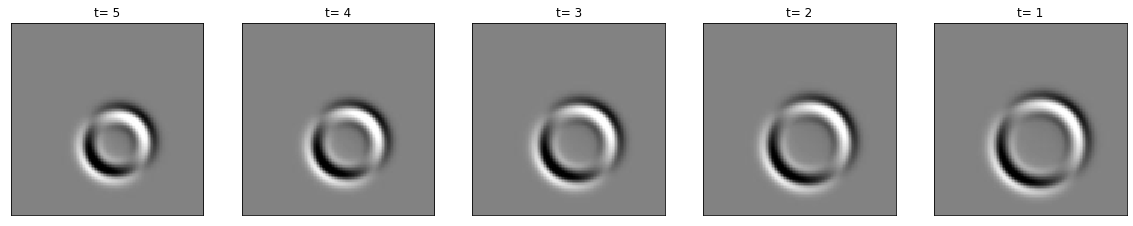

In [538]:
fig, ax = plt.subplots(1, 5, figsize = (20, 4))

for t in range(5):
    ax[t].imshow(input_frames[0, t, :, :], cmap='gray', vmin=0, vmax=1)
    ax[t].set_title('t= %d' % (5-t))
    ax[t].get_xaxis().set_ticks([])
    ax[t].get_yaxis().set_ticks([])
plt.show()

In [539]:
activation.keys()

dict_keys(['encoder.stage1.conv1_leaky_1', 'encoder.stage1.leaky_conv1_leaky_1', 'encoder.stage1', 'encoder.rnn1._conv', 'encoder.rnn1', 'encoder.stage2.conv2_leaky_1', 'encoder.stage2.leaky_conv2_leaky_1', 'encoder.stage2', 'encoder.rnn2._conv', 'encoder.rnn2', 'encoder.stage3.conv3_leaky_1', 'encoder.stage3.leaky_conv3_leaky_1', 'encoder.stage3', 'encoder.rnn3._conv', 'encoder.rnn3', 'encoder', 'forecaster.rnn3._conv', 'forecaster.rnn3', 'forecaster.stage3.deconv1_leaky_1', 'forecaster.stage3.leaky_deconv1_leaky_1', 'forecaster.stage3', 'forecaster.rnn2._conv', 'forecaster.rnn2', 'forecaster.stage2.deconv2_leaky_1', 'forecaster.stage2.leaky_deconv2_leaky_1', 'forecaster.stage2', 'forecaster.rnn1._conv', 'forecaster.rnn1', 'forecaster.stage1.deconv3_leaky_1', 'forecaster.stage1.leaky_deconv3_leaky_1', 'forecaster.stage1.conv3_leaky_2', 'forecaster.stage1.leaky_conv3_leaky_2', 'forecaster.stage1.conv3_3', 'forecaster.stage1', 'forecaster', ''])

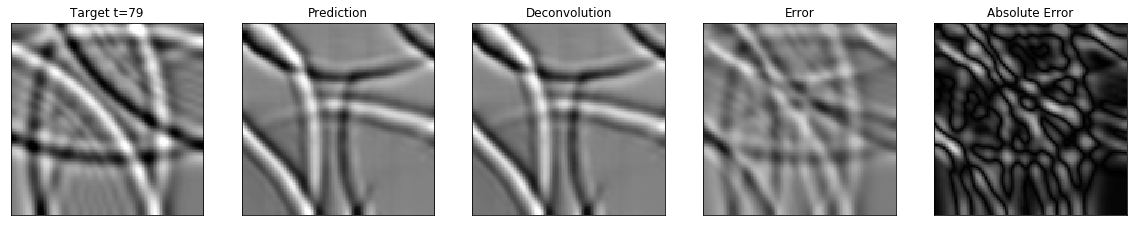

Deconv and Prediction error (should be zero): 0.000000
prediction error 0.186308


In [630]:
deconv_name = 'forecaster.stage1.conv3_3'
dconv_norm = image_prepro(activation[deconv_name].squeeze()[-1,:], experiment.normalizer)

t=num_total_output_frames-1
fig, ax = plt.subplots(1, 5, figsize = (20, 4))
ax[0].imshow(target_frames[0, t, :, :], cmap='gray', vmin=0, vmax=1)
ax[1].imshow(output_frames[0, t, :, :], cmap='gray', vmin=0, vmax=1)
ax[2].imshow(dconv_norm, cmap='gray', vmin=0, vmax=1)
ax[3].imshow((target_frames[0, t, :, :] - output_frames[0, t, :, :]), cmap='gray', vmin=-1, vmax=1)
ax[4].imshow(abs(target_frames[0, t, :, :] - output_frames[0, t, :, :]), cmap='gray', vmin=0, vmax=1)

ax[0].set_title('Target t=%d'%t)
ax[1].set_title('Prediction')
ax[2].set_title('Deconvolution')
ax[3].set_title('Error')
ax[4].set_title('Absolute Error')

for a in ax:
    a.get_xaxis().set_ticks([])
    a.get_yaxis().set_ticks([])
plt.show()

print('Deconv and Prediction error (should be zero): %f' % (output_frames[0, t, :, :] - dconv_norm).abs().mean())
print("prediction error %f" % (target_frames[0, t, :, :] - dconv_norm).abs().mean())

In [541]:
for k,v in activation.items():
    try:
        print(k, v.size())
    except:
        pass

encoder.stage1.conv1_leaky_1 torch.Size([5, 8, 64, 64])
encoder.stage1.leaky_conv1_leaky_1 torch.Size([5, 8, 64, 64])
encoder.stage1 torch.Size([5, 8, 64, 64])
encoder.rnn1._conv torch.Size([1, 256, 64, 64])
encoder.stage2.conv2_leaky_1 torch.Size([5, 192, 32, 32])
encoder.stage2.leaky_conv2_leaky_1 torch.Size([5, 192, 32, 32])
encoder.stage2 torch.Size([5, 192, 32, 32])
encoder.rnn2._conv torch.Size([1, 768, 32, 32])
encoder.stage3.conv3_leaky_1 torch.Size([5, 192, 16, 16])
encoder.stage3.leaky_conv3_leaky_1 torch.Size([5, 192, 16, 16])
encoder.stage3 torch.Size([5, 192, 16, 16])
encoder.rnn3._conv torch.Size([1, 768, 16, 16])
forecaster.rnn3._conv torch.Size([1, 768, 16, 16])
forecaster.stage3.deconv1_leaky_1 torch.Size([10, 192, 32, 32])
forecaster.stage3.leaky_deconv1_leaky_1 torch.Size([10, 192, 32, 32])
forecaster.stage3 torch.Size([10, 192, 32, 32])
forecaster.rnn2._conv torch.Size([1, 768, 32, 32])
forecaster.stage2.deconv2_leaky_1 torch.Size([10, 64, 64, 64])
forecaster.stage2

In [542]:
def print_activations(act_name, index_t, lines, rows):
    act = activation[act_name][index_t,:]
    print(act.size())
    fig, axarr = plt.subplots(lines, rows, figsize=(rows, lines))
    for i in range(lines):
        for k in range(rows):
            a = i*rows +k
#             print(i,k,a)
            if (a < act.size(0)):
                axarr[i, k].imshow(act[a,:], cmap='gray', vmin=act.min(), vmax=act.max())
            axarr[i, k].set_yticks([])
            axarr[i, k].set_xticks([])
    plt.show()

torch.Size([8, 64, 64])


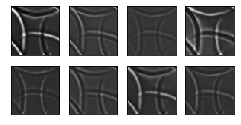

In [543]:
print_activations('encoder.stage1.conv1_leaky_1', index_t=0,  lines = 2, rows = 4)

torch.Size([256, 64, 64])


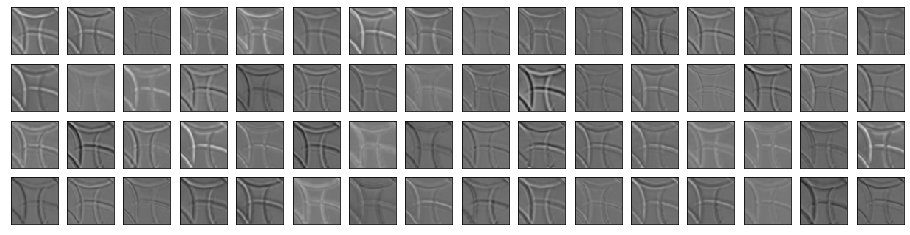

In [544]:
print_activations('encoder.rnn1._conv', index_t=0,  lines = 4, rows = 16)

torch.Size([192, 32, 32])


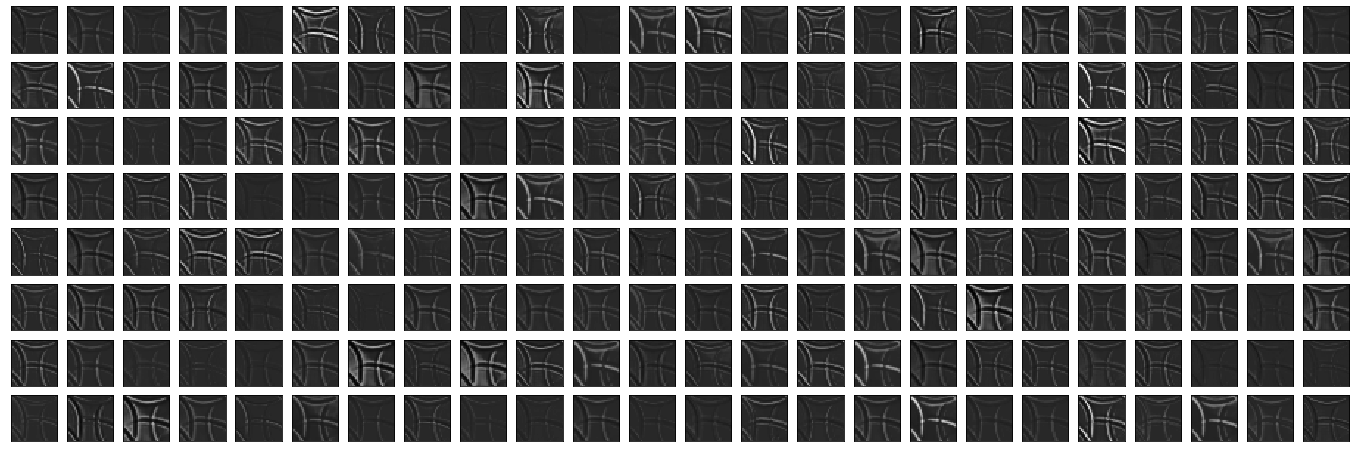

In [545]:
print_activations('encoder.stage2.conv2_leaky_1', index_t=0,  lines =8, rows = 24)

torch.Size([768, 32, 32])


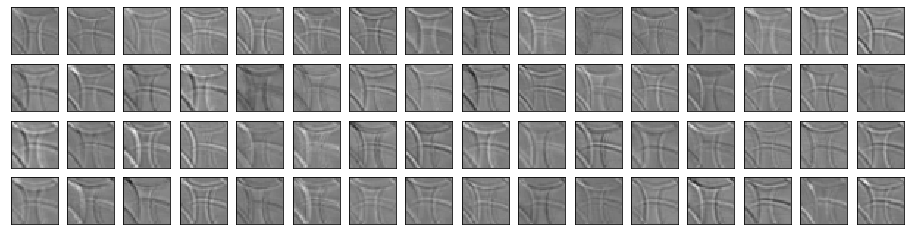

In [546]:
print_activations('encoder.rnn2._conv', index_t=0,  lines = 4, rows = 16)

torch.Size([192, 16, 16])


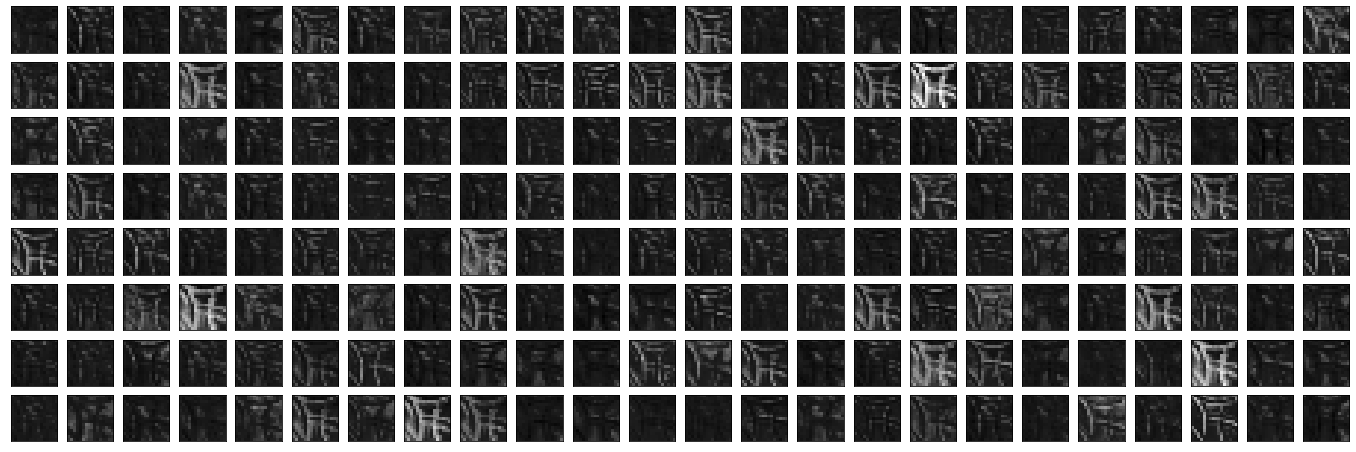

In [547]:
print_activations('encoder.stage3.conv3_leaky_1', index_t=0,  lines =8, rows = 24)

torch.Size([768, 16, 16])


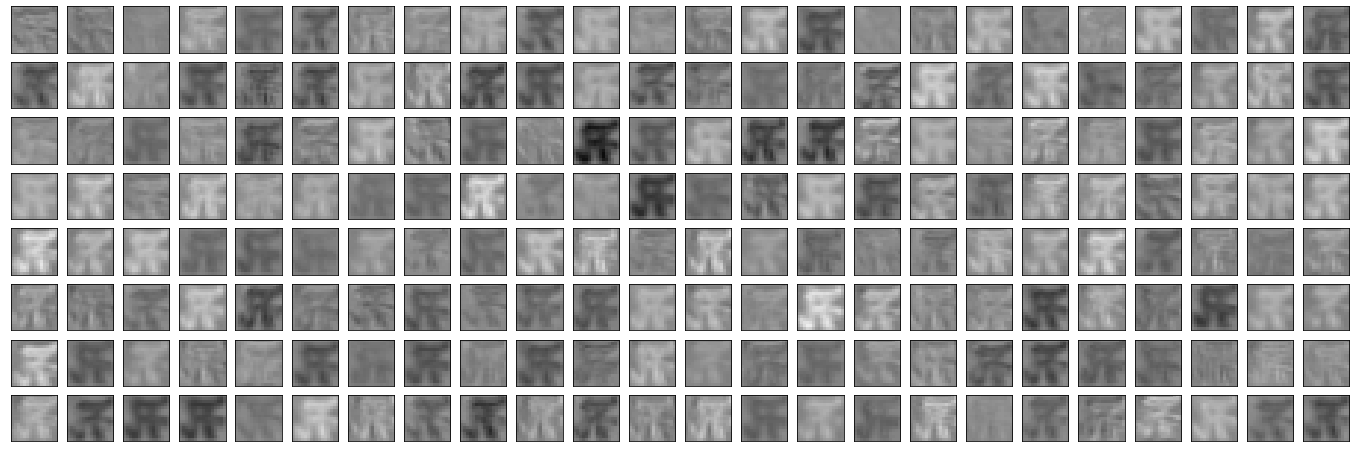

In [548]:
print_activations('encoder.rnn3._conv', index_t=0,  lines = 8, rows = 24)

torch.Size([768, 16, 16])


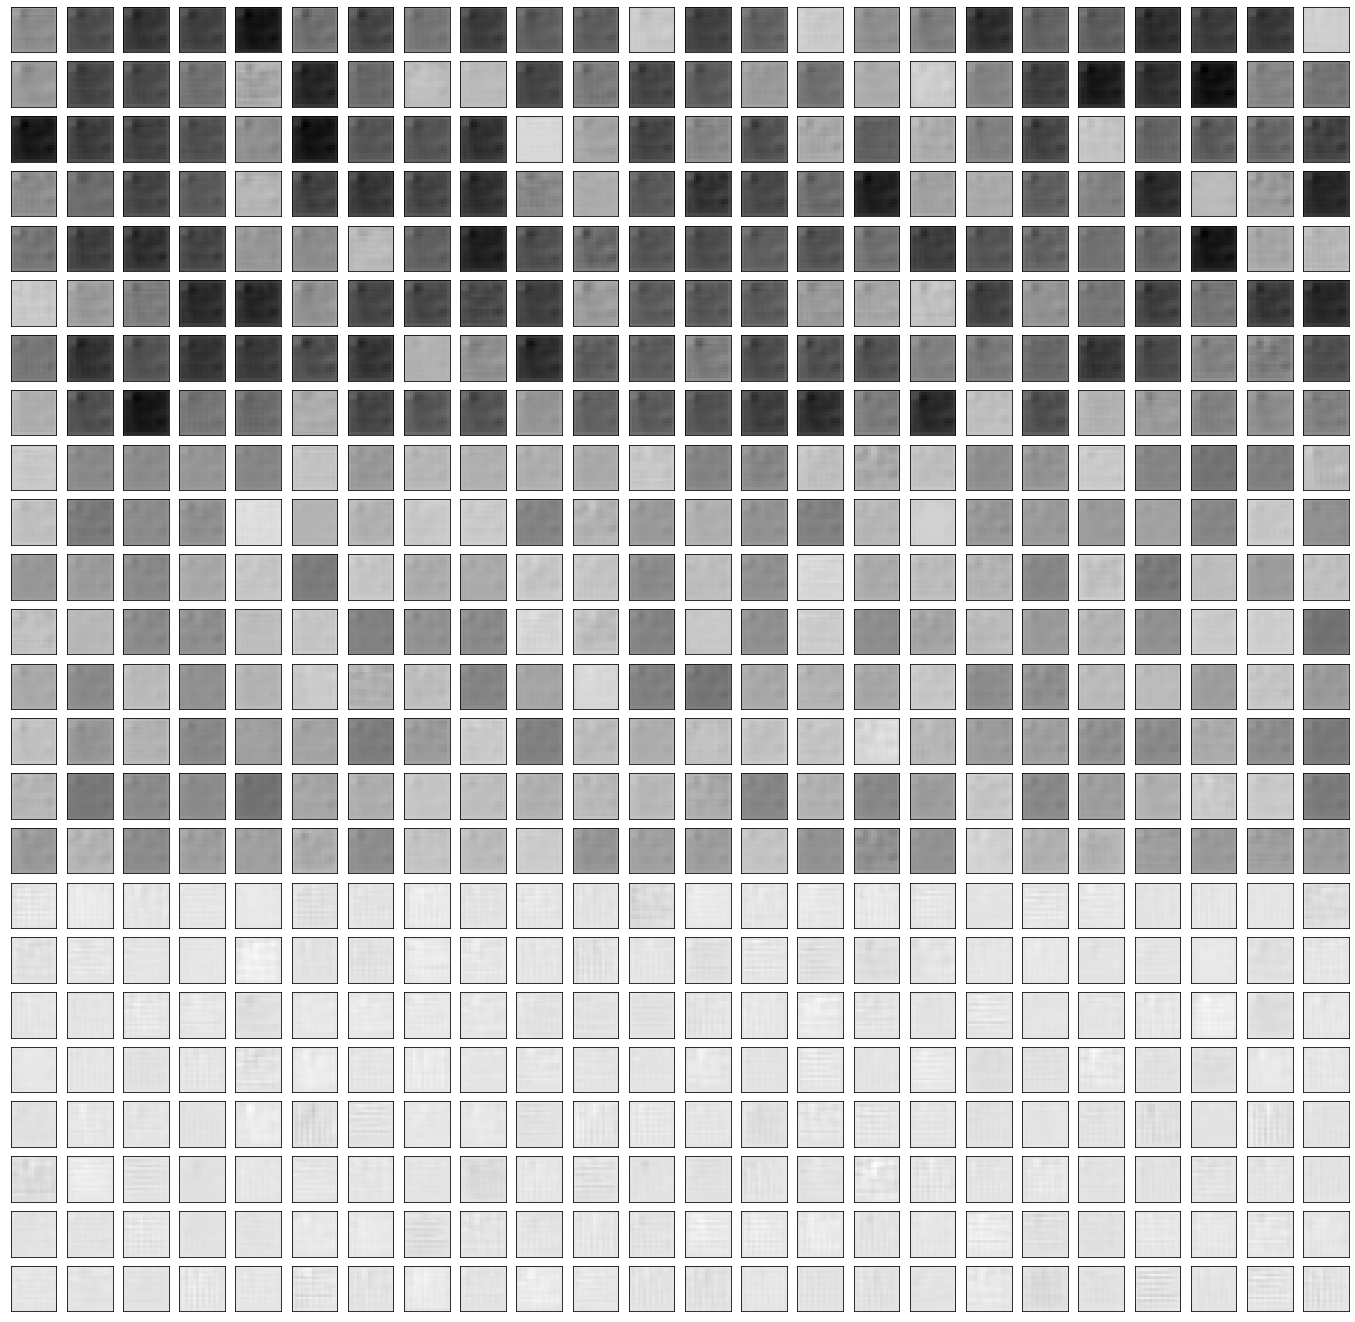

In [549]:
print_activations('forecaster.rnn3._conv', index_t=0,  lines = 24, rows = 24)

torch.Size([192, 32, 32])


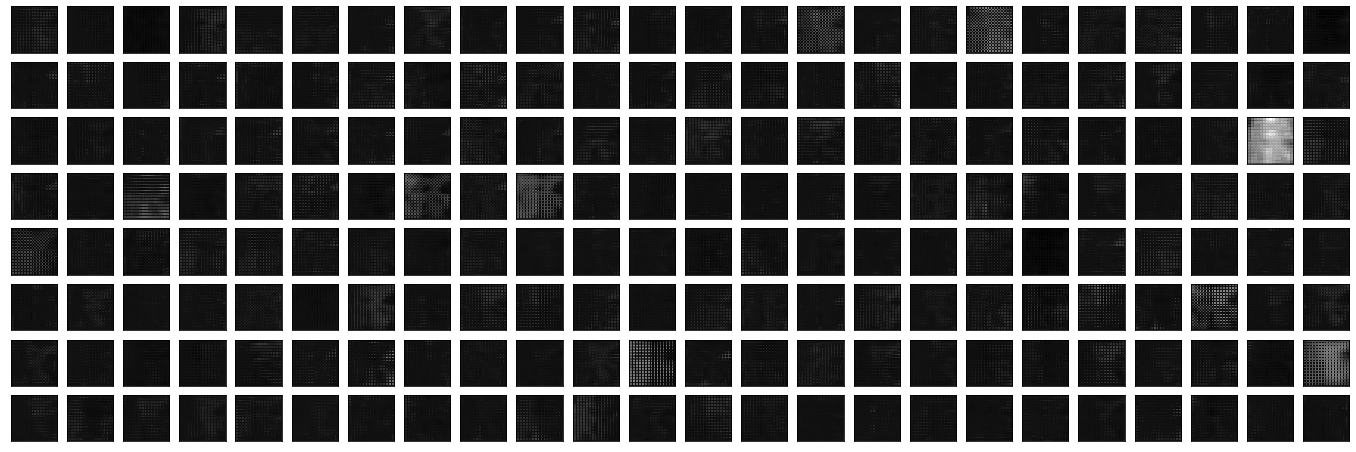

In [642]:
print_activations('forecaster.stage3.deconv1_leaky_1', index_t=0,  lines=8, rows = 24)

torch.Size([768, 32, 32])


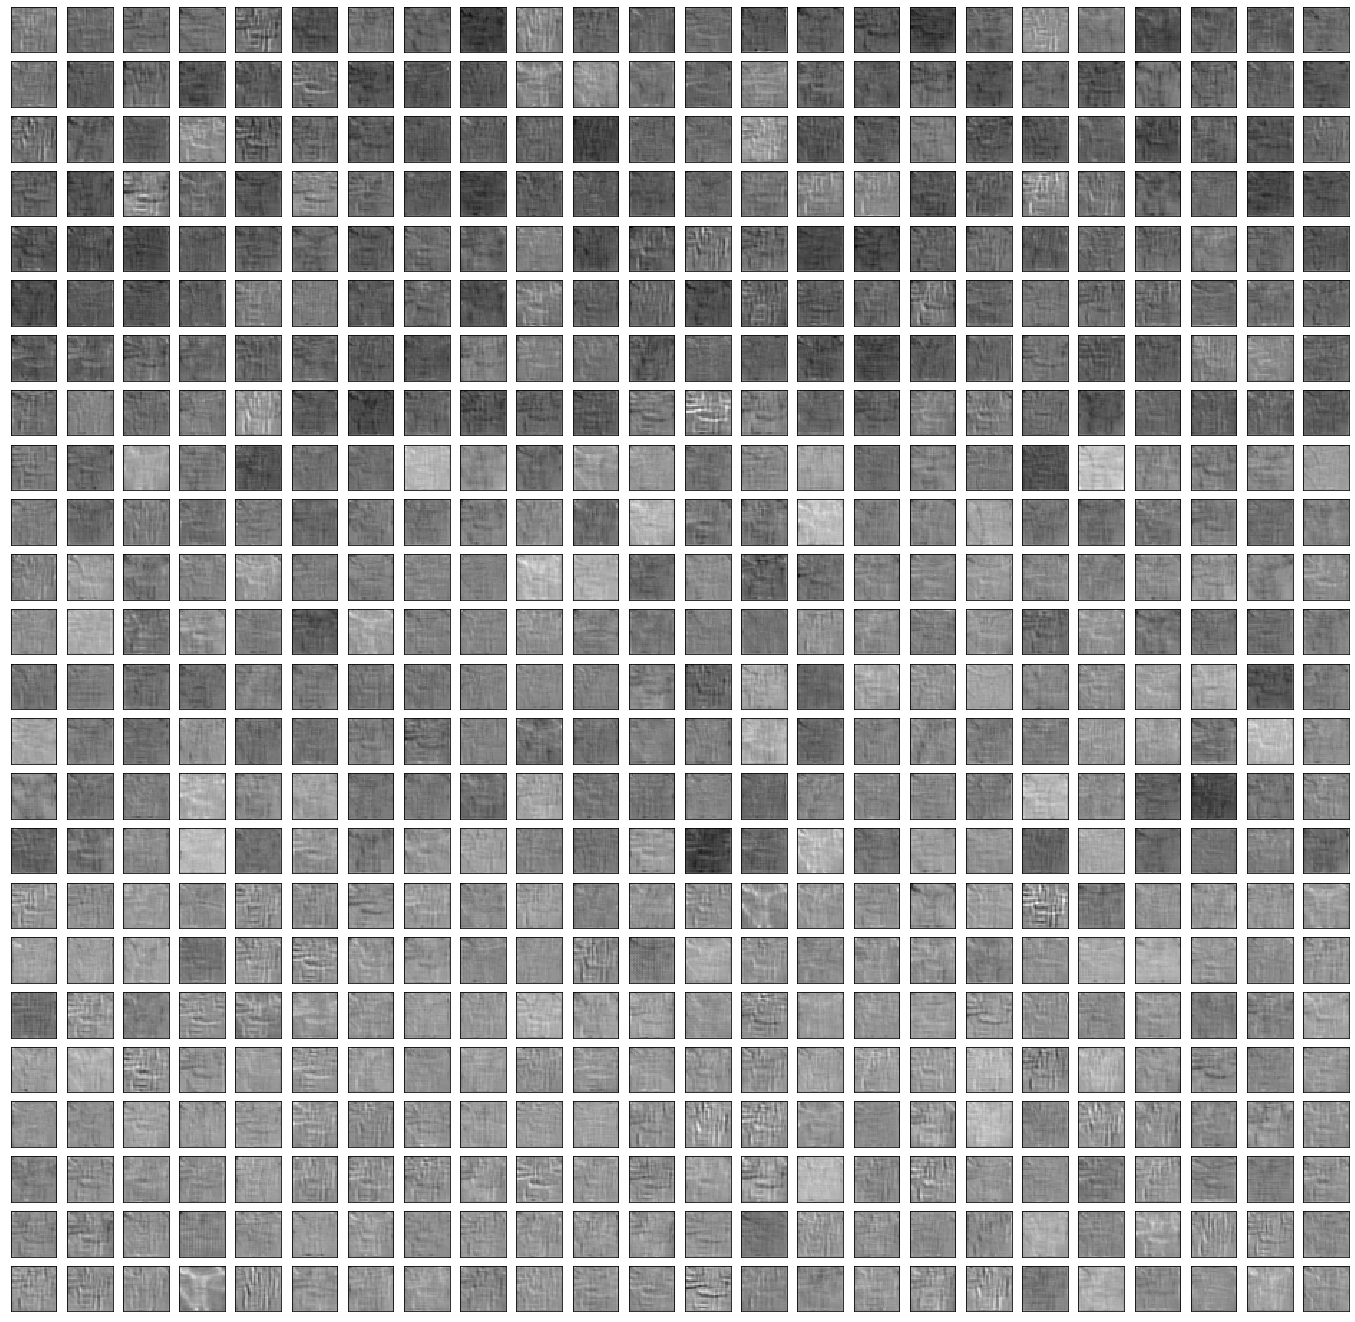

In [551]:
print_activations('forecaster.rnn2._conv', index_t=0,  lines = 24, rows = 24)

torch.Size([64, 64, 64])


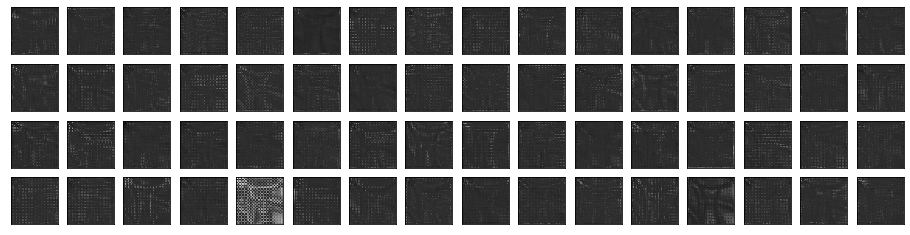

In [552]:
print_activations('forecaster.stage2.deconv2_leaky_1', index_t=0,  lines=4, rows = 16)

torch.Size([256, 64, 64])


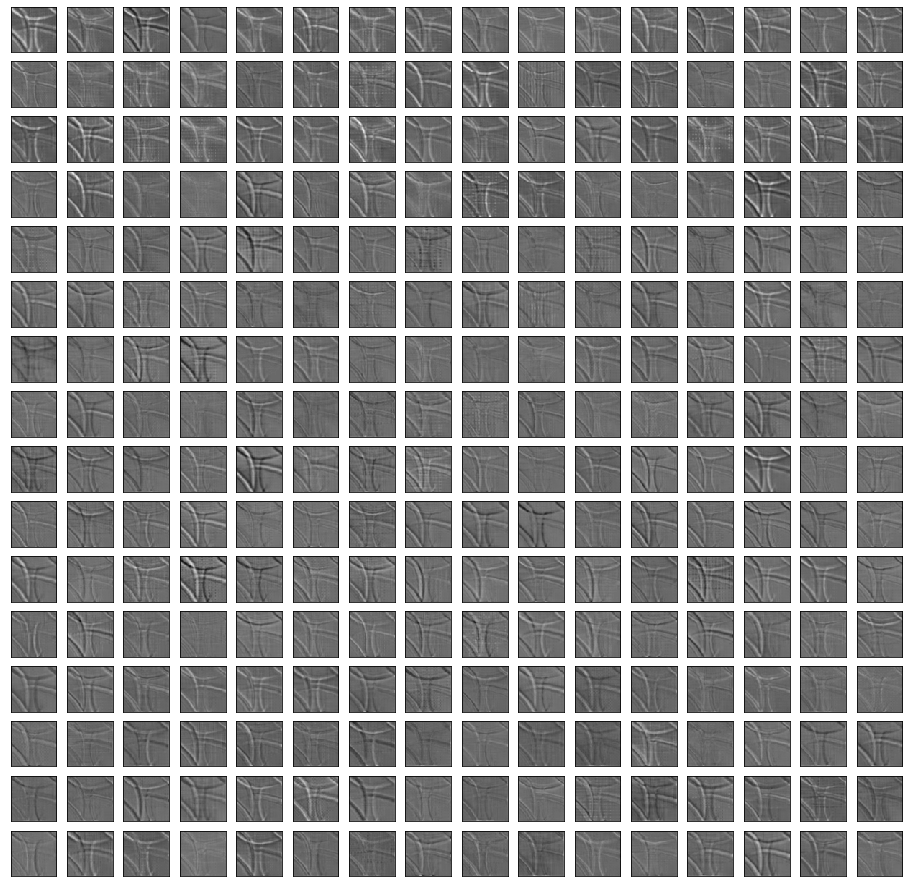

In [553]:
print_activations('forecaster.rnn1._conv', index_t=0,  lines = 16, rows = 16)

torch.Size([8, 128, 128])


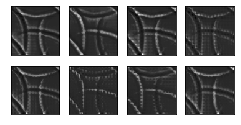

In [554]:
print_activations('forecaster.stage1.deconv3_leaky_1', index_t=0,  lines=2, rows = 4)

torch.Size([8, 128, 128])


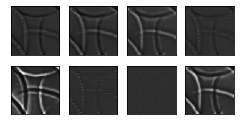

In [555]:
print_activations('forecaster.stage1.conv3_leaky_2', index_t=0,  lines=2, rows = 4)

torch.Size([1, 128, 128])


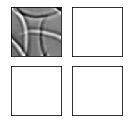

In [556]:
print_activations('forecaster.stage1.conv3_3', index_t=0,  lines=2, rows = 2)

In [631]:
activation['forecaster.stage1.conv3_leaky_2'].size()

torch.Size([10, 8, 128, 128])

In [632]:
last = activation['forecaster.stage1.conv3_leaky_2'][-1,:,:]

In [633]:
w = params['forecaster.stage1.conv3_3.weight'].squeeze()
b = params['forecaster.stage1.conv3_3.bias']

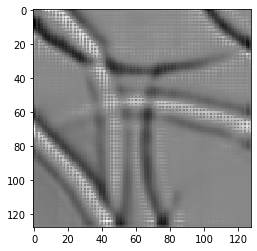

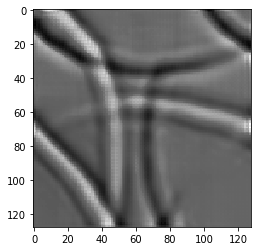

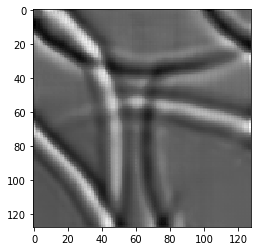

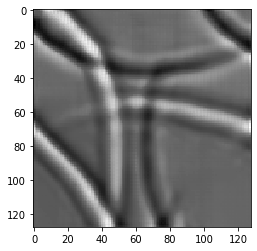

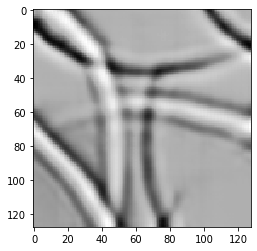

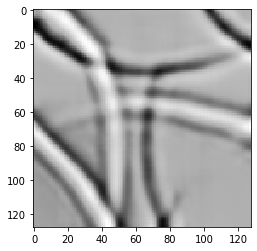

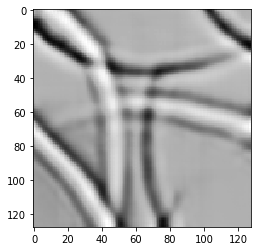

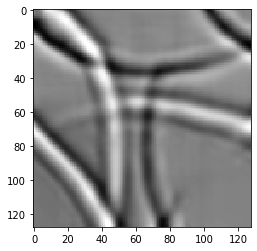

In [638]:
img = torch.zeros_like(last[0])
for i in range(8):
    img += last[i] * w[i]
    plt.imshow(image_prepro(img + b, experiment.normalizer), cmap='gray')
    plt.show()

In [626]:
output_frames.size()

torch.Size([1, 80, 128, 128])

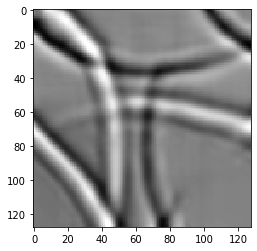

In [637]:
plt.imshow(image_prepro(output_frames[0,-1,:], experiment.normalizer),cmap='gray')
plt.show()